# Pouso de meteoritos no planeta terra

- Iara Araujo
- Beatriz Barreto 
- Paloma Duarte

## Introdução

### Motivação e objetivo

## Dados utilizados

### Dataset meteorite_landings
- Dados coletados pela [meteorical society](https://meteoritical.org/), incluindo localizações, massas,composições e ano de queda 
para mais de 45.000 meteoritos que caíram no planeta terra.
- Variáveis desse dataset:
    - **name**: nome do meteorito(geralmente relacionado com a localização onde atingiu a terra).
    - **id** : identificador único para o meteorito no dataset.
    - **nametype**: classificação do meteorito em **relict** ou **valid**
    - **mass** : a massa do meteorito dada em gramas.
    - **fell**: classificação do meteorito em:
        - _Fall_: se foi identificado durante sua queda.
        - _Fell_: se foi identificado após sua queda.
    - **year**: ano em que o meteorito foi identificado.
    - **reclat**: latitude da posição em que o meteoro foi encontrado.
    - **reclong**: longitude da posição em que o meteoro foi encontrado.
    - **GeoLocation**: junção da latitude e da longitude em uma variável, separadas por vírgula.    
- Observações adicionais
    - as variáveis 'reclat' e 'reclong' são "valores recomendados", isto é levemente alterados do valor inicialmente dado, isso se deve a uma reclassificação do meteorito ou alteração dos dados originais de sua coleta.
    - alguns dados estão incorretos ou com difícil visualização, por isso faremos a limpeza na fase de pré processamento.


---
### Dataset meteorite_landings_on_earth
- Dados coletados e disponibilizados pela [NASA](https://data.nasa.gov/), incluindo registros de 45.000 meteoritos com dados de detalhamento extras, como nome do país/oceano encontrado.
- Variáveis do dataset:
    - **id** : identificador único para o meteorito dentro do dataset.
    - **meteorite_name**: nome do meteorito.
    - **nametype**: classificação do meteorito em **relict** ou **valid**
    - **recclass**: é o processo de passagem de uma classe, classificação ou categoria para outra.
    - **fall**: classificação do meteorito em:
        - _Fall_: se foi identificado durante sua queda.
        - _Fell_: se foi identificado após sua queda.
    - **year**: ano em que o meteorito foi identificado.
    - **mass** : a massa do meteorito dada em gramas.
    - **location**: nome do país ou oceano em que o meteorito foi encontrado.
    - **location_code**: código de identificação do país ou oceano em que o meteorito foi encontrado.
    - **location_type**: tipo de localização do local em que o meteoro foi encontrado, classificado em:
        - _Land_: se foi identificado na terra.
        - _Ocean_: se foi identificado no oceano.
        - _Unknown_: se foi identificado em um local que pode ter mudado de classificação de terra para oceano, ou visse-versa, desde sua queda.
    - **distance**: deslocamento do meteorito desde sua queda.
    - **latitude**: latitude da posição em que o meteorito foi encontrado.
    - **longitude**: longitude da posição em que o meteorito foi encontrado.
    - **lat_lng**: junção da latitude e da longitude em uma variável, separadas por vírgula.

In [2]:
import pandas as pd
import numpy as np
import math
from math import log
import statistics
import seaborn as sns
from scipy.stats import linregress
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv('datasets/meteorite_landings.csv', on_bad_lines='warn')
df2 = pd.read_csv('datasets/meteorite_landings_on_earth.csv', on_bad_lines='warn')   #lendo os datasets
df3 = pd.read_csv('datasets/cneos_fireball_data.csv', on_bad_lines='warn')

## Pré-processamento dos dados

### Dataset meteorite_landings

#### Corrigindo dados na variável 'year'

- Aqui faremos uma verificação do ano em que o meteorito foi descoberto, pois existem algumas incoerências. 
  
  Faremos essa verificação utilizando como base o site [The Meteoritical Society](https://www.lpi.usra.edu/meteor/metbull.php).
  

In [4]:

years_bug = [i for i in df1['year'] if i >= 2016 or i <= 860 ] # pega os anos incoerentes

index_bug = [i for i in df1.index if df1.loc[i, 'year'] in years_bug] # pega os índices dos elementos problemáticos 

name_years_bug = [df1['name'].loc[i] for i in df1.index if df1.loc[i, 'year'] in years_bug] # pega o nome dos elementos para a verificação no site

print(name_years_bug)
index_bug


['Nogata', 'Havana', 'Northwest Africa 7701', 'Ur', 'Wietrzno-Bobrka']


[703, 16356, 30679, 38188, 38301]

- Agora vamos corrigir as informações no dataframe:

In [11]:
years_bug = [i for i in df1['year'] if i >= 2016 or i <= 860 ] # pega os anos incoerentes

index_bug = [i for i in df1.index if df1.loc[i, 'year'] in years_bug] # pega os índices dos elementos problemáticos 



df1 = df1.drop(index_bug) #removendo os rows em que os anos são problemáticos


#### Corrigindo dados das variáveis 'reclat' e 'reclong'

In [7]:
df1['reclong'] = df1['reclong'].map(lambda x : 61.074319 if (x > 180 or x < - 180) else x) #correção de incoerências das colunas 'reclat' e 'reclong'
df1['reclat'] = df1['reclat'].map(lambda x : -39.122580 if (x == 0) else x)

#### Criando escala logarítmica para variáveis 'mass' e 'year'

In [22]:
df1['log mass'] = np.log10(df1['mass']) #criando a escala em log para diminuir a distorção
                                        #ele deu esse erro, mas produziu mesmo assim

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
year_copy = (df1[df1['year'] > 0]).copy()

df1['log year'] = np.log10(year_copy['year'])

#sns.boxplot(data=df1, x='log year') #utilizando a escala em log para a variável 'year'.


## Exploração inicial 

### Dataset meteorite_landings

#### Medidas de centralidade

- Medianas

In [8]:
print((df1.sort_values(by='year', ascending=False).dropna()['year']).median()) # mediana de 'year'

print((df1.sort_values(by='mass', ascending=False).dropna()['mass']).median()) # mediana de 'mass'

print((df1.sort_values(by='reclat', ascending=False).dropna()['reclat']).median()) # mediana de 'reclat'

print((df1.sort_values(by='reclong', ascending=False).dropna()['reclong']).median()) # mediana de 'reclong'


1996.0
29.08
-71.5
35.66667


- Médias


In [9]:
df1.mean(numeric_only='True')

id         26889.736628
mass       13278.932641
year        1991.851331
reclat       -45.690505
reclong       61.071807
dtype: float64

- Modas

In [10]:
df1.mode(dropna='True')[['mass', 'year', 'fall', 'recclass']].head(1)

,mass,year,fall,recclass
0,1.3,2003.0,Found,L6


#### Medidas de dispersão

- Desvio padrão

In [9]:
df1.std(numeric_only=True).dropna() 

id          16860.791462
mass       575007.788451
year           24.478620
reclat         43.021263
reclong        80.633287
dtype: float64

- Variâncias

In [14]:
df1.var(numeric_only=True).dropna()

id         2.842863e+08
mass       3.306340e+11
year       5.992028e+02
reclat     1.850829e+03
reclong    6.501727e+03
dtype: float64

- Alguns boxplots e visualizações

<AxesSubplot:xlabel='log mass'>

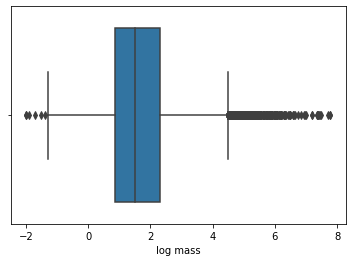

In [25]:
sns.boxplot(data=df1, x="log mass") # boxplot da variável 'mass' em escala logarítmica

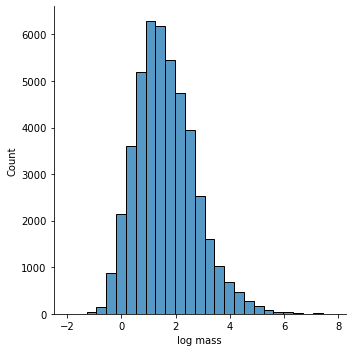

In [27]:
sns.displot(data=df1,x='log mass', bins=27) # Histograma da variável 'mass' em escala logarítmica

<AxesSubplot:ylabel='Frequency'>

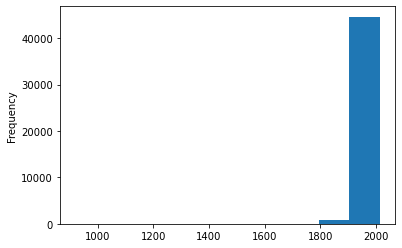

In [18]:
df1['year'].plot.hist() # Histograma da variável year

<AxesSubplot:xlabel='log year'>

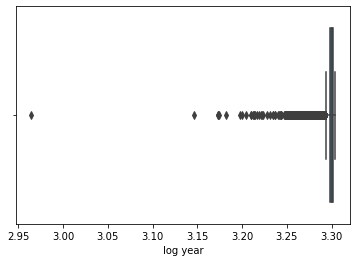

In [20]:
year_copy = (df1[df1['year'] > 0]).copy()

df1['log year'] = np.log10(year_copy['year'])

sns.boxplot(data=df1, x='log year') #utilizando a escala em logarítmica

# Boxplot variável year em escala logarítmica

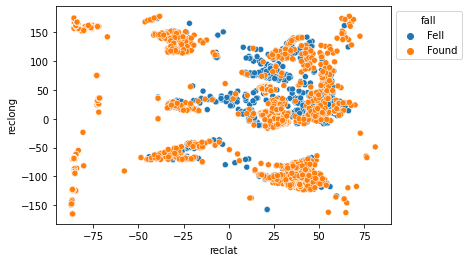

In [30]:
ax = sns.scatterplot(data=df1, x='reclat',y='reclong', hue='fall') # Gráfico exibindo as localizações onde meteoritos caíram e se foram ou não vistos caindo.
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

## Perguntas

### Quais os maiores meteoros a atingirem a Terra?

In [12]:
ord_massa = df1[['name','mass']].sort_values(by='mass',ascending=False).dropna() #Os meteoritos com maiores massas registradas
ord_massa

,name,mass
16383,Hoba,60000000.0
5336,Cape York,58200000.0
5329,Campo del Cielo,50000000.0
5333,Canyon Diablo,30000000.0
3433,Armanty,28000000.0
...,...,...
31065,Österplana 053,0.0
31066,Österplana 054,0.0
31067,Österplana 055,0.0
31068,Österplana 056,0.0


- Os 5 meteoritos com maior massa em ordem descrescente são: Hoba com 60000000 gramas, Cape York com 58200000 gramas, Campo del Cielo 50000000 gramas, Canyon Diablo com 30000000 gramas e Armanty com 28000000 gramas. 

### Qual a média anual de meteoritos a atingirem o planeta?

In [13]:
cont_years = df1[['year']].value_counts().sort_values(ascending=False) #contando os anos existentes para o cálculo da média.

cont_years

year  
2003.0    3323
1979.0    3046
1998.0    2697
2006.0    2456
1988.0    2296
          ... 
1628.0       1
1741.0       1
1623.0       1
1575.0       1
920.0        1
Length: 263, dtype: int64

In [14]:
#263 anos existentes e 45582 meteoritos registrados.

met_por_ano = 45582/263

met_por_ano

# a média anual de meteoritos por ano é de 173. Podemos analisar que a média é afetada por anos onde a concentração de meteoritos foi maior, pois "173 meteoritos p/ano" 
# não expressa nitidamente a realidade, uma vez que existem anos onde apenas 1 meteorito foi registrado.

173.31558935361215

- A média anual de meteoritos por ano é de 173. Podemos analisar que a média é afetada por anos onde a concentração de meteoritos foi maior, pois "173 meteoritos p/ano"  não expressa nitidamente a realidade, uma vez que existem anos onde apenas 1 meteorito foi registrado.